# Interactive tutorial: supervised machine learning in microbiomics

This Colab notebook is an accompaniment to the paper "Supervised machine learning in microbiomics: bridging the gap between current and best practices" (**ADD CITATION**).

In this tutorial, we will develop a machine learning (ML) classifier that predicts whether an individual has schizophrenia based on the composition of their fecal microbiota. Data was sourced from [Zhu, Feng, et al. "Metagenome-wide association of gut microbiome features for schizophrenia." Nature communications 11.1 (2020): 1612.](https://www.nature.com/articles/s41467-020-15457-9), and consists of shotgun sequencing of fecal samples from 90 medication-free schizophrenia patients and 81 controls. Controls and schizophrenia patients were matched for demographic features. For more information about the clinical trial under which data was collected, including the study design and eligibility criteria, see [clinicaltrials.gov, identifier NCT02708316](https://clinicaltrials.gov/ct2/show/NCT02708316?term=NCT02708316&draw=2&rank=1).

If you're new to Colab:

- To run this notebook, you'll need to make your own copy by going to File > Save a copy in Drive.
- Code in cells can be run by clicking the play button on the lefthand side of the cell with your cursor or by using the keyboard shortcut "Command/Ctrl+Enter".
- To learn more about Colab, check out the [documentation](https://colab.research.google.com/#scrollTo=-Rh3-Vt9Nev9) and [FAQ](https://research.google.com/colaboratory/faq.html).

In [1]:
# Automatically upload modules
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import dill
import numpy as np
import pandas as pd
import shap
from mealy.error_analyzer import ErrorAnalyzer
from mealy.error_visualizer import ErrorVisualizer
#from scipy.stats import median_abs_deviation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from ml4microbiome import data_visualization, pre_process, stats, train

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
BASE_DIR = "./"

DATA_PATH = "zhu_metaphlan_read_counts.txt"
METADATA_PATH = "zhu_supplemental.tsv"

## Experimental goals and design

In this tutorial, we'll develop an ML classifier that can predict whether an individual has schizophrenia based on the composition of their gut microbiota. This work is motivated by the following questions:
1. Does the microbiome have predictive value for the diagnosis of schizophrenia? If so:
2. What methodological ML parameters (i.e., learning algorithm, features) yield the highest predictive results?
3. Which microbial taxa provide value for predicting whether an individual has schizophrenia?

Because this dataset is fairly small (n=171), our analysis will focus on understanding whether the microbiota has predictive value and, if so, under what experimental conditions and whether we can extract scientific insights. If our goal was to quantitatively evaluate the model's performance (without test set omission or leakage), we would need to either a) obtain an external validation set on which to evaluate model performance, or b) split the current dataset into discovery and validation sets to develop and evaluate model performance on, respectively. Given the small size of this and similar microbiome datasets that are available for people diagnosed with schizophrenia, our ability to provide a robust estimate model performance would likely be limited.

To generate features from raw shotgun sequencing data, we will perform QC, remove human contamination, and infer the taxonomic composition of the samples (methods described below). 

Once taxonomic features have been generated, the following pre-processing steps will be performed: 
- CLR transformation of taxonomic data
- Imputatation of missing metadata values
- Feature scaling of numerical metadata features

We will then compare the performance of models trained using the following parameters:
- Different learning algorithms (random forest, L1 logistic regression, LightGBM)
- Different types of features (metadata only, microbiome data only, combination thereof - more information on specifics below)
- Different taxonomic levels (species, genus, family, all taxonomic levels)

To train models and evaluate performance, we will use repeated k-fold cross-validation (CV). This will allow us to perform multiple replicates of the experiment, using different training-test splits and model initialization states. The results will be used to reject or support the hypothesis that microbiome data holds predictive value for the diagnosis of schizophrenia. If this hypothesis is supported, we will identify which experimental parameters yield the highest performing ML classifier. Note that we will not make claims about the performance of the model on a population level due to our use of repeated k-fold CV to select a best model and the lack of an external validation set on which to evaluate that best model. Where statistics are applied to support comparisons, we will use a p-value threshold of 0.5 to assess significance.

Finally, should our classifier/s have predictive value, we will perform interpretability and error analyses to better understand how the model is making predictions and under what circumstances it may perform more or less well. 

**Best practices:**
- **Carefully identify and frame appropriate ML tasks.** Our task has clearly defined goals and the experiment has been carefully designed and scoped.
- **Assess project feasibility given available resources.** For the purpose of this tutorial case study, we will assess the following:  
    1. Do we have suitable data (volume and quality) to achieve our goals? Through a review of the literature, including the study from which data here was sourced, it appears that others have had success building predictive classifiers for schizophrenia using similar dataset sizes. There is deep sequencing coverage of samples (average of >11 Gbp) and metadata appears to be well definied and consistently labeled.
    2. Do we have the computational resources required to train a model? We are working with a small dataset (n=171 samples) and will be training models using relatively simple learning algorithms such as logisitic regression. We expect that this analysis can realistically be run on Colab or a laptop. 
    3. Do we have the expertise on our team to successfully develop an ML model using microbiome data? We have a combination of machine learning and microbiome domain expertise on our team.

- **Consider using repeated k-fold CV or nested CV to train and evaluate models when dataset size is limited.** Taking into account our limited dataset size and study goals, we have decided to apply repeated k-fold CV. This will allow us to perform experimental replicates that will improve our estimate of model performance while also providing insight into the experimental conditions that yield the highest predictive results. Notably, our experimental design does not allow us to make quantitative claims about model performance because we have no truly independent test set upon which to evaluate performance.

## Generating features from raw data

Before developing our ML models, we need to first generate features from the raw sequencing data and perform some light cleaning of the associated metadata. 

Raw reads were downloaded from the [European Nucleotide Archive Project PRJEB29127](https://www.ebi.ac.uk/ena/browser/view/PRJEB29127). Quality control analysis with FastQC v0.11.9 (Andrews, 2010) and MultiQC v1.12 (Ewels *et al*., 2016), revealing that reads in the dataset had high quality scores across their lengths and that there was minimal adapter content remaining. As such, we proceeded to remove human contamination by mapping reads against human reference genome [GRCh38.p14](https://www.ncbi.nlm.nih.gov/data-hub/genome/GCF_000001405.40/) using bowtie2 v2.5.1 (Langmead & Salzberg, 2012). 

The taxonomic composition of samples was inferred  using [Metaphlan4](https://huttenhower.sph.harvard.edu/metaphlan/) (Segata *et al*., 2012; Blanco-Miguez *et al*., 2022) and the Jan 2021 ChocoPhlAn3 database as a reference (Beghini *et al*., 2021). Metaphlan4 was run with the -t rel_ab_w_read_stats flag to obtain read counts per taxon - this will later be normalized using the CLR transformation. One of the strengths of shotgun sequencing is that it can be used to profile the bacteria, archaea, eukaryotes, and viruses in a sample, all of which can influence community ecology and host phenotype. By default, Metaphlan4 will profile bacterial, archaeal, and eukaryotic taxa. We added the --add_viruses flag to include information about viral taxa present in metagenomes. 

**Best practices:**

- **Ensure that your work is reproducible.** We have noted the tools, versions, and parameters used to process data. 

In [119]:
df = pd.read_csv(BASE_DIR + DATA_PATH, sep="\t", header=1, index_col=0)
df.head()

,wHAXPI032581-18,wHAXPI032582-19,wHAXPI032583-21,wHAXPI032584-22,wHAXPI032585-23,wHAXPI032586-25,wHAXPI032587-26,wHAXPI032588-27,wHAXPI032589-28,wHAXPI032590-29,...,wHAXPI034926-15,wHAXPI037144-8,wHAXPI037145-9,wHAXPI037146-11,wHAXPI037147-12,wHAXPI043592-8,wHAXPI043593-9,wHAXPI043594-11,wHAXPI047830-11,wHAXPI048670-90
clade_name,,,,,,,,,,,,,,,,,,,,,
UNCLASSIFIED,3494672.0,6754349.0,4260914.0,6187478.0,2674039.0,7947679.0,5613767.0,866739.0,3572242.0,244159.0,...,0.0,8123538.0,14037729.0,1826625.0,0.0,7334007.0,2717037.0,1497137.0,24400.0,1965115.0
k__Bacteria,55201537.0,47765462.0,52657193.0,52561280.0,59600789.0,55916608.0,49243118.0,49442596.0,46909477.0,2645156.0,...,88900925.0,58777577.0,58748372.0,73703777.0,67259161.0,76057026.0,84384204.0,78882064.0,61148785.0,53749396.0
k__Bacteria|p__Bacteroidetes,33897963.0,46389419.0,39207459.0,49916347.0,37934782.0,38316045.0,13636655.0,35392296.0,40287619.0,2071752.0,...,80858718.0,40154561.0,51010514.0,41339096.0,56440790.0,67479230.0,68517753.0,67397038.0,47634395.0,31936734.0
k__Bacteria|p__Firmicutes,17430112.0,1186849.0,12641757.0,2330571.0,19271903.0,14195178.0,21301098.0,12746923.0,6349586.0,553860.0,...,5928344.0,14832338.0,6835368.0,25314983.0,7948970.0,7234829.0,12394020.0,6367626.0,8208873.0,18262886.0
k__Bacteria|p__Candidatus_Melainabacteria,1305775.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31815.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It is essential that ML practitioners understand the format of raw input data before developing models. Here, we are working with the profile file output by Metaphlan4. 

Each column represents a sample and each row represents a taxon that was identified in the dataset. Values in cells represent the number of reads per sample attributed to a given taxon. For every taxonomic level (kingdom, phylum, ... genus, species), metaphlan outputs the read counts of all taxa identified at that level. Taxonomic levels are denoted by "k__" for kingdom, "p__" for phylum, ..., "g__" for genus, "s__" for species, "t__" for strain. This means that some rows will be redundant. For example, reads asigned to the species *Escherichia coli* will also be counted under genus *Escherichia*, family Enterobacteriaceae, Order Enterobacterales, Phylum Pseudomonadota, and Kingdom Bacteria. 

For more information, see the [Metaphlan4 tutorial](https://github.com/biobakery/biobakery/wiki/metaphlan4#131-the-metaphlan-taxonomic-profile).

Before going any further, we'll do data cleaning / relabeling for ease of analysis downstream.

In [5]:
df_metadata = pd.read_csv(
    BASE_DIR + METADATA_PATH, skiprows=3, index_col=0, sep="\t"
).iloc[:, :-4]
df_metadata = df_metadata.replace(
    to_replace="Xi'An Mental Health Center", value="Xi'an"
)
df_metadata.head()

,Age,"Gender (1:male, 2:female)",Marital status,Dwelling condition,Education level,Sample center,BMI,Group,Diagnosis,Height(cm),...,In the past six months exposure to secondhand smoke situation,Tryptophane(μM),Glutamic acid(μM),Tyrosine(μM),Phenylalanine(μM),Dopamine(ng/ml),Gamma-aminobutyric acid (GABA)(ng/L),Serotonin(ng/ml),Kynurenine (KYN)(nmol/L),Kynurenic acid (KYNA)(nmol/L)
BGI ID,,,,,,,,,,,,,,,,,,,,,
wHAXPI032581-18,25,2,single,group living,college,Xi'an,19.47,HC,healthy,165,...,almost none,1.0516,12.422,80.545284,63.896120,13.024398,361.400990,897.702,272.868494,19.118564
wHAXPI032582-19,31,1,married,famliy life,junior college,Xi'an,21.77,HC,healthy,166,...,less than 1 hour a day,1.4955,19.352,75.147635,66.953205,20.294400,505.238478,876.188,246.388882,28.348535
wHAXPI032583-21,20,2,single,group living,college,Xi'an,18.96,SCZ,first-episode,164,...,almost none,0.9545,11.134,60.190960,49.082874,13.337798,126.780552,3855.892,282.426914,21.620503
wHAXPI032584-22,14,1,single,famliy life,junior high school,Xi'an,16.02,SCZ,first-episode,158,...,less than 1 hour a day,1.0566,14.501,90.816270,72.480174,16.201674,318.151574,4676.200,278.668462,18.302654
wHAXPI032585-23,27,1,single,famliy life,primary school,Xi'an,19.61,SCZ,relapse,172,...,almost none,0.7695,10.197,51.945472,48.217204,8.616032,312.728082,676.074,326.729434,47.202890


In [6]:
df_metadata.isnull().any().any()

True

Looking at the metadata, a couple things to note are:
- Some metadata columns contain NaNs, we will perform imputation to deal with those later. Importantly, imputation must be done after the training-test split for model evaluation, so as to avoid data leakage.
- Categorical features such as "Gender" have been one hot encoded.
- Behavioural features may be affected by whether or not an individual is aware that they have diagnosed schizophrenia. For example, an individual with severe schizophrenia may be more or less likely to live in a certain type of housing ("Dwelling condition"). Since we want to develop a classifier that would theoretically be able to predict whether individuals without diagnosed schizophrenia may have schizophrenia, we will not include behavioural features in our ML model.

## Data Exploration

Before designing our ML experiment, we will perform exploratory data analysis to understand the characteristics of the dataset we are working with. In part this is to inform ourselves and readers about the patient demographics our model was developed and evaluated on, and partly this provides information that assures us that data pre-processing has been completed satisfactorily. 

Here, we will evaluate features such as:
- Dataset size
- Demographics of the population sampled
- Technical features relating to how the data was generated (e.g.: collection, sampling, and processing methods)
- Properties of the sequenced dataset, such as the number of species identified by Metaphlan4

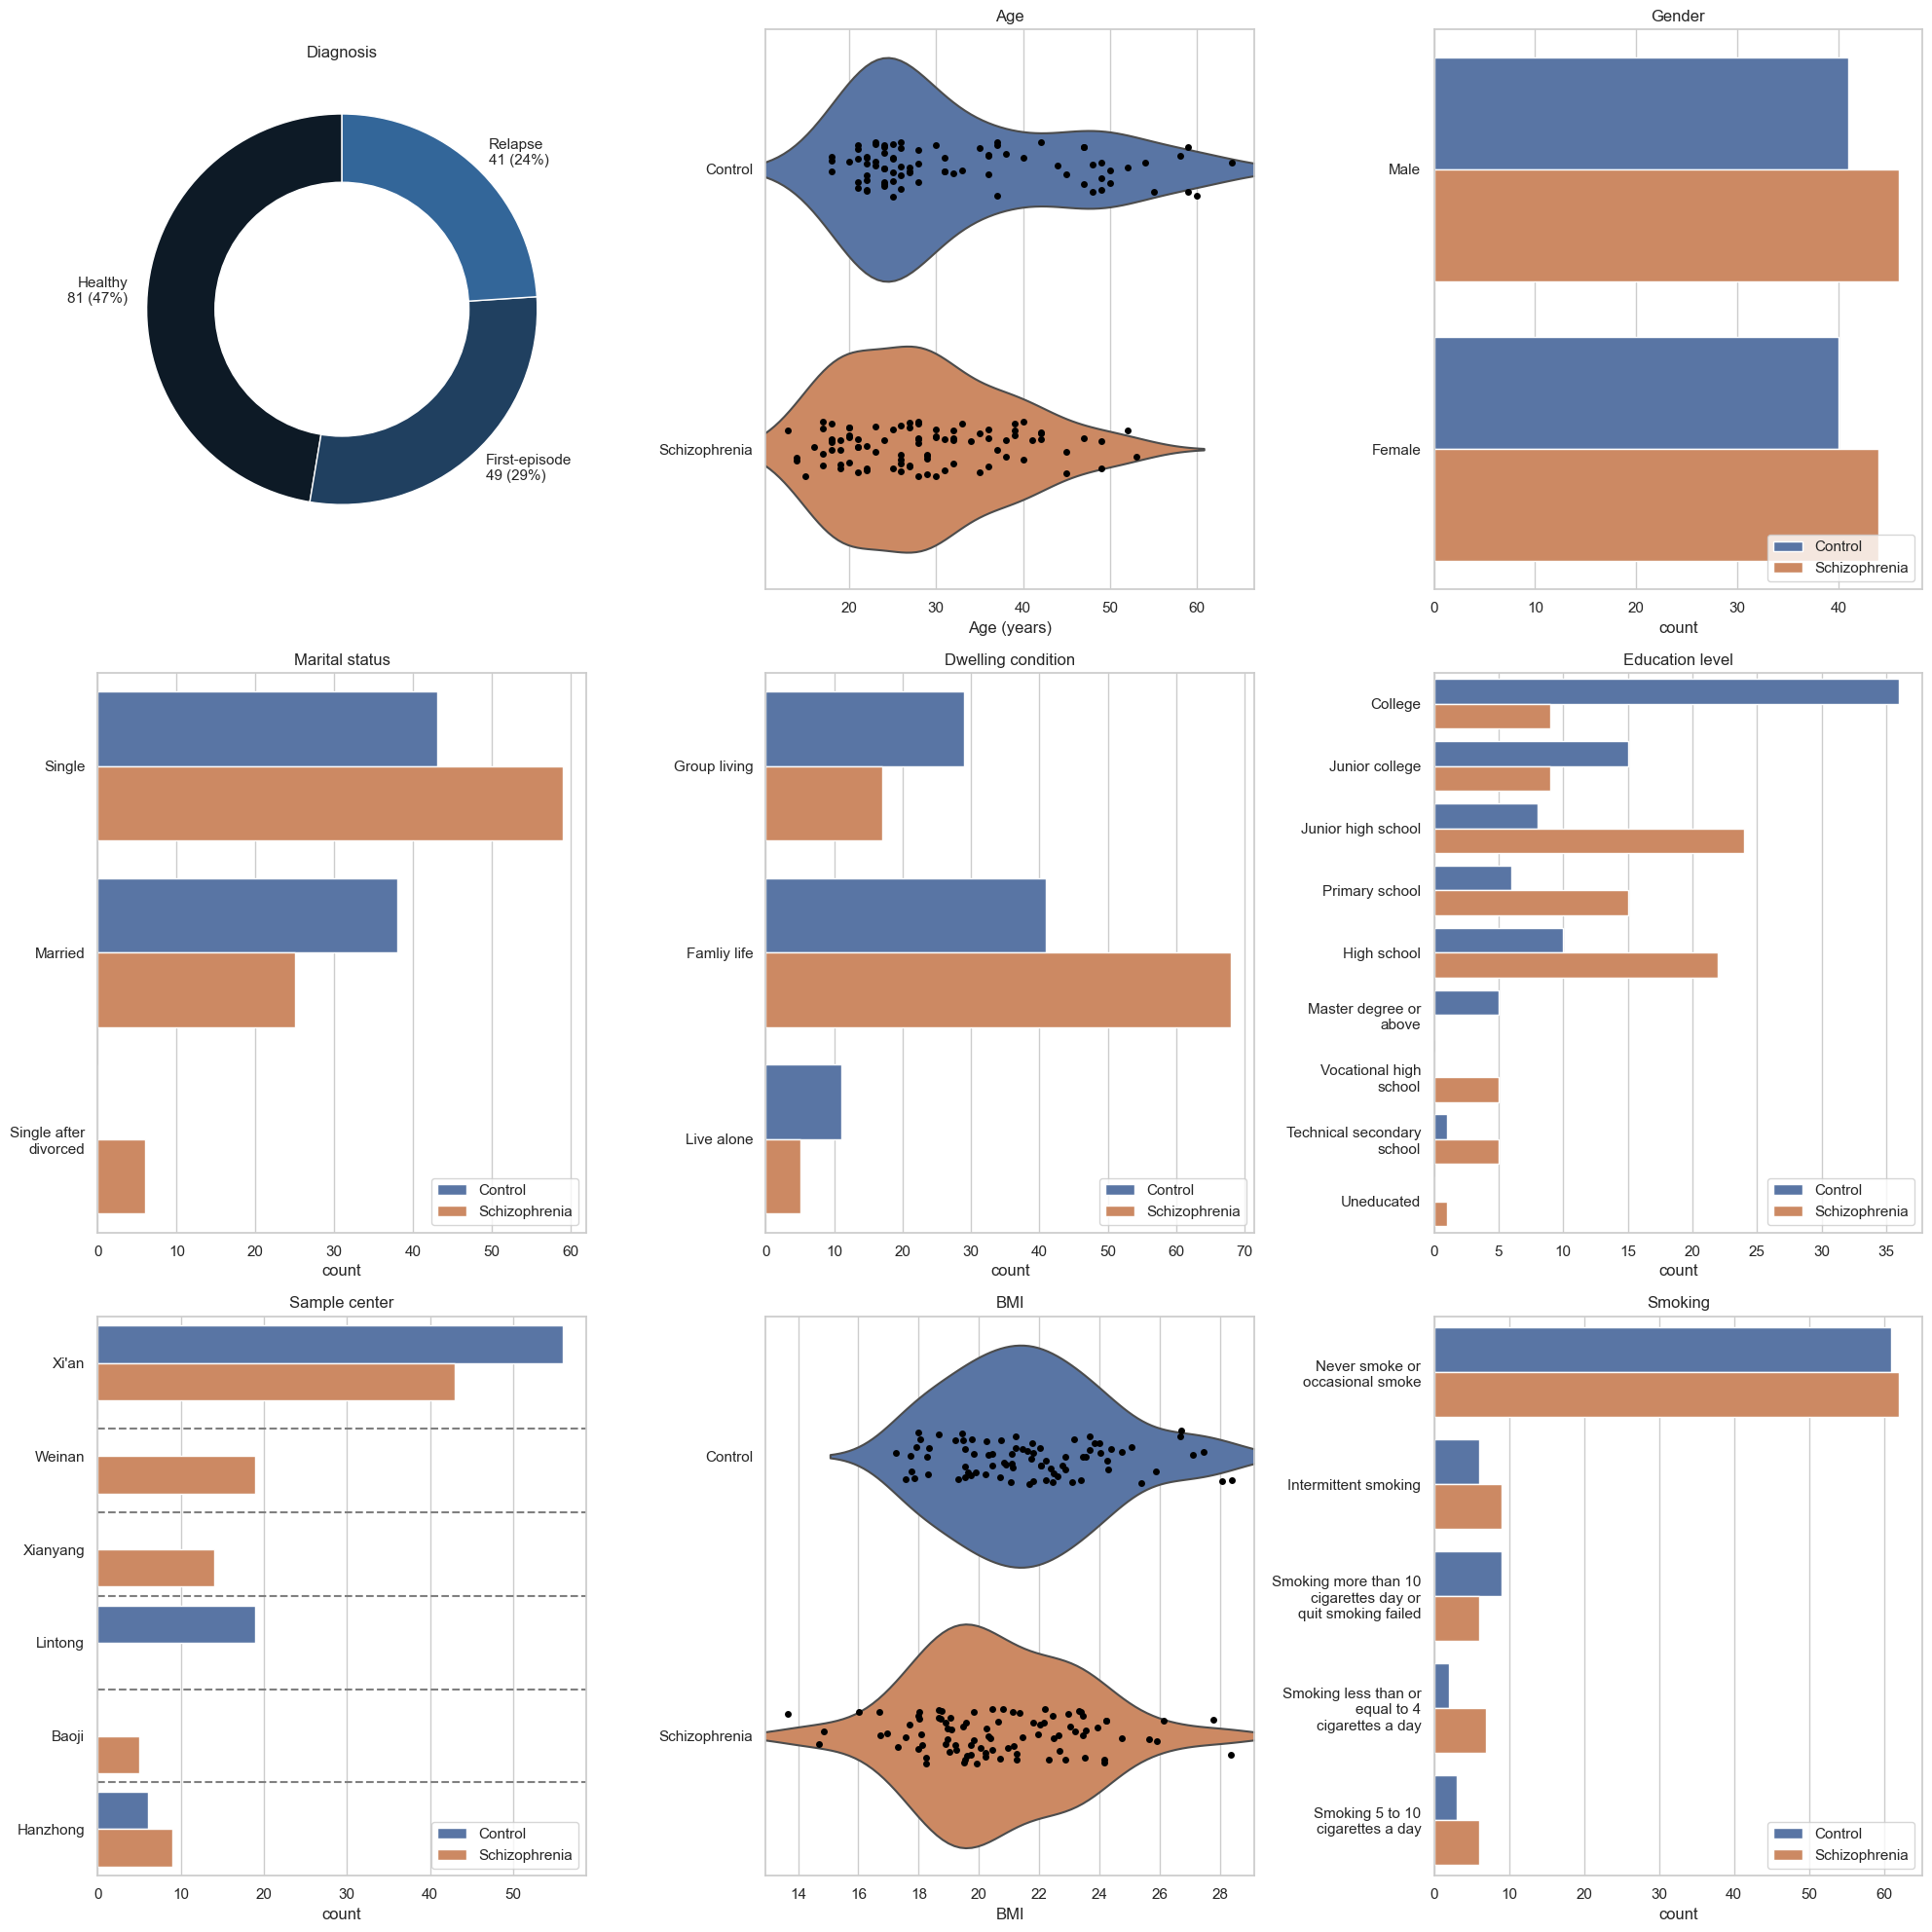

In [7]:
fig = data_visualization.plot_demographics(df_metadata)

Key takeaways: 
- Visually we can see that age, gender, BMI, and smoking habits are similar in the control vs schizophrenia groups. Meanwhile, marital status, dwelling conditions, education level, and sample center seem to be distributed differently in the present sample of control vs schizophrenia groups. In a research study, it would be important to statistically investigate the degree to which control vs experimental groups are matched across different demographic features.
- These are important sources of bias to keep in mind, especially when we assess model performance. For example, one could imagine that sampling center results in a shift in microbial community composition due to contamination from the built environment, processing kits, etc. If center A specializes in the treatment of schizophrenia (e.g., 90% of samples from center A are from individuals with schizphrenia), a model could hypothetically learn a shortcut whereby it predicts whether a sample is from center A based on contaminants and then predicts a patient has schizophrenia.

Now we will visually explore whether there is a difference in blood based biomarkers collected for individuals with vs without schizophrenia.

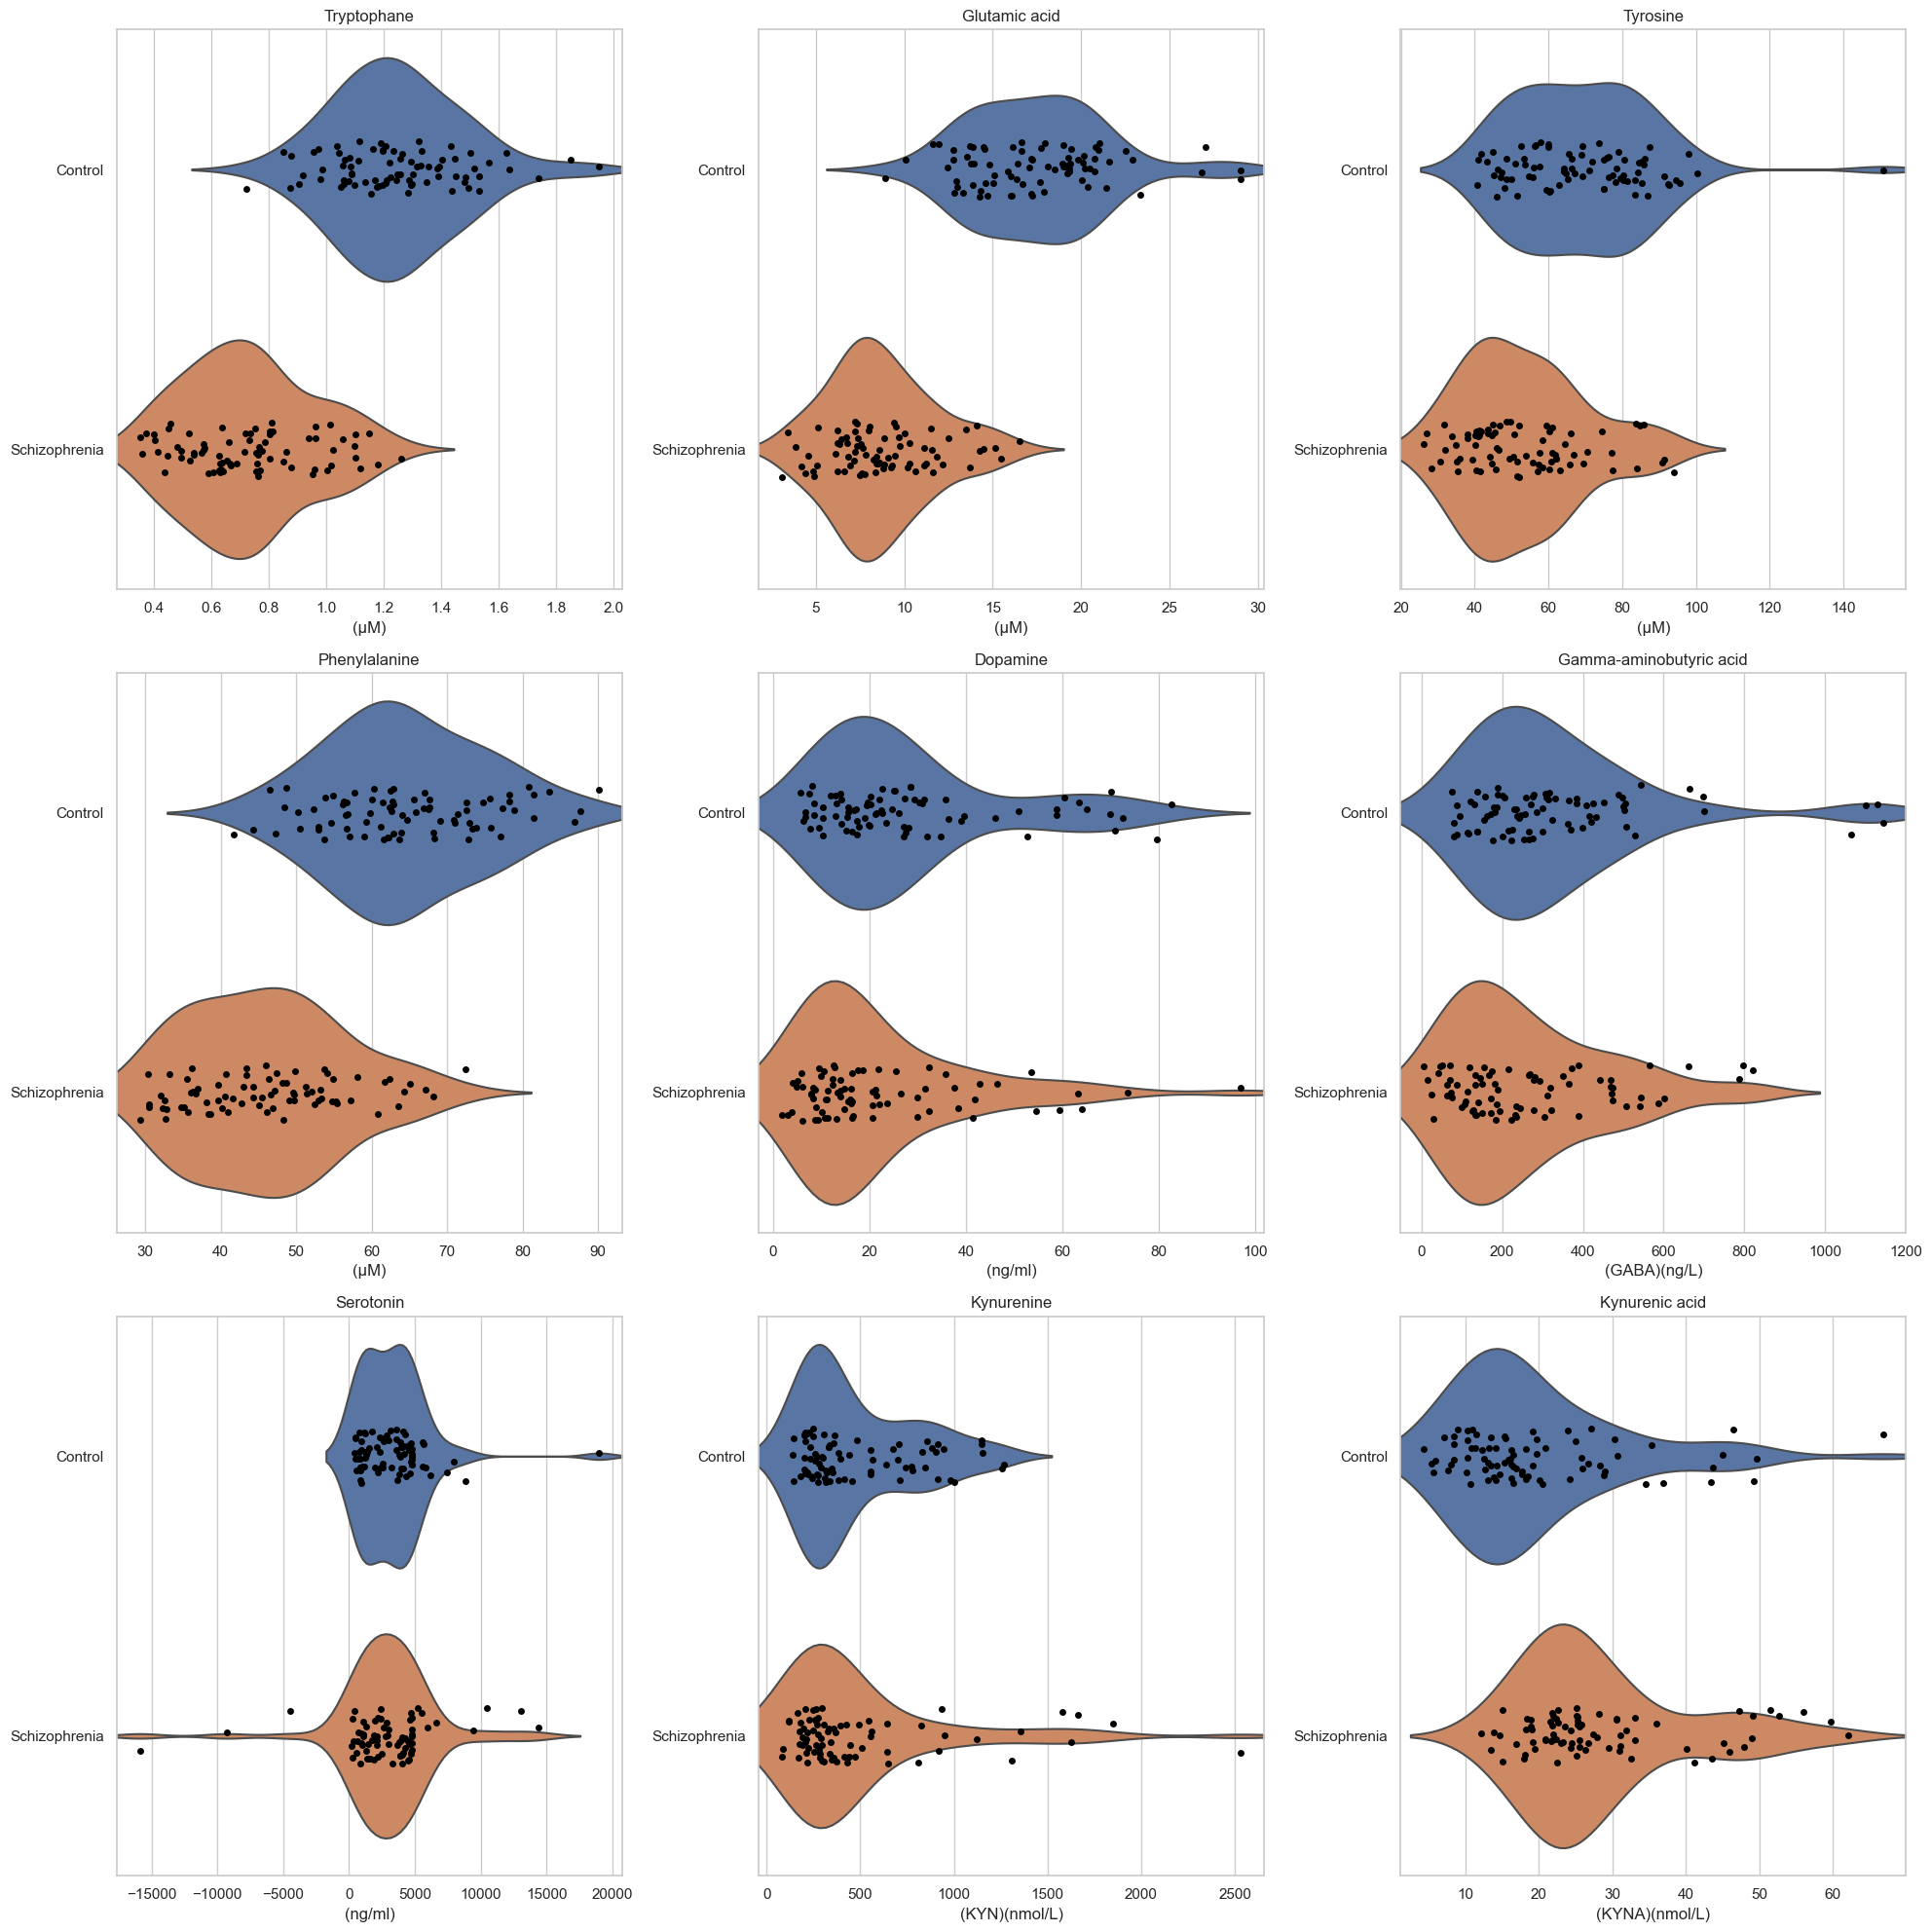

In [8]:
fig = data_visualization.plot_blood_based_biomarkers(df_metadata)

Key takeaways:
- Just by eye, we can see that the distribution of blood based biomarkers seems to be different between people with and without schizophrenia. 

Now let's look at the composition of the microbiota in individuals with and without schizophrenia, and see whether we can spot any obvious differences by eye or by t-SNE.

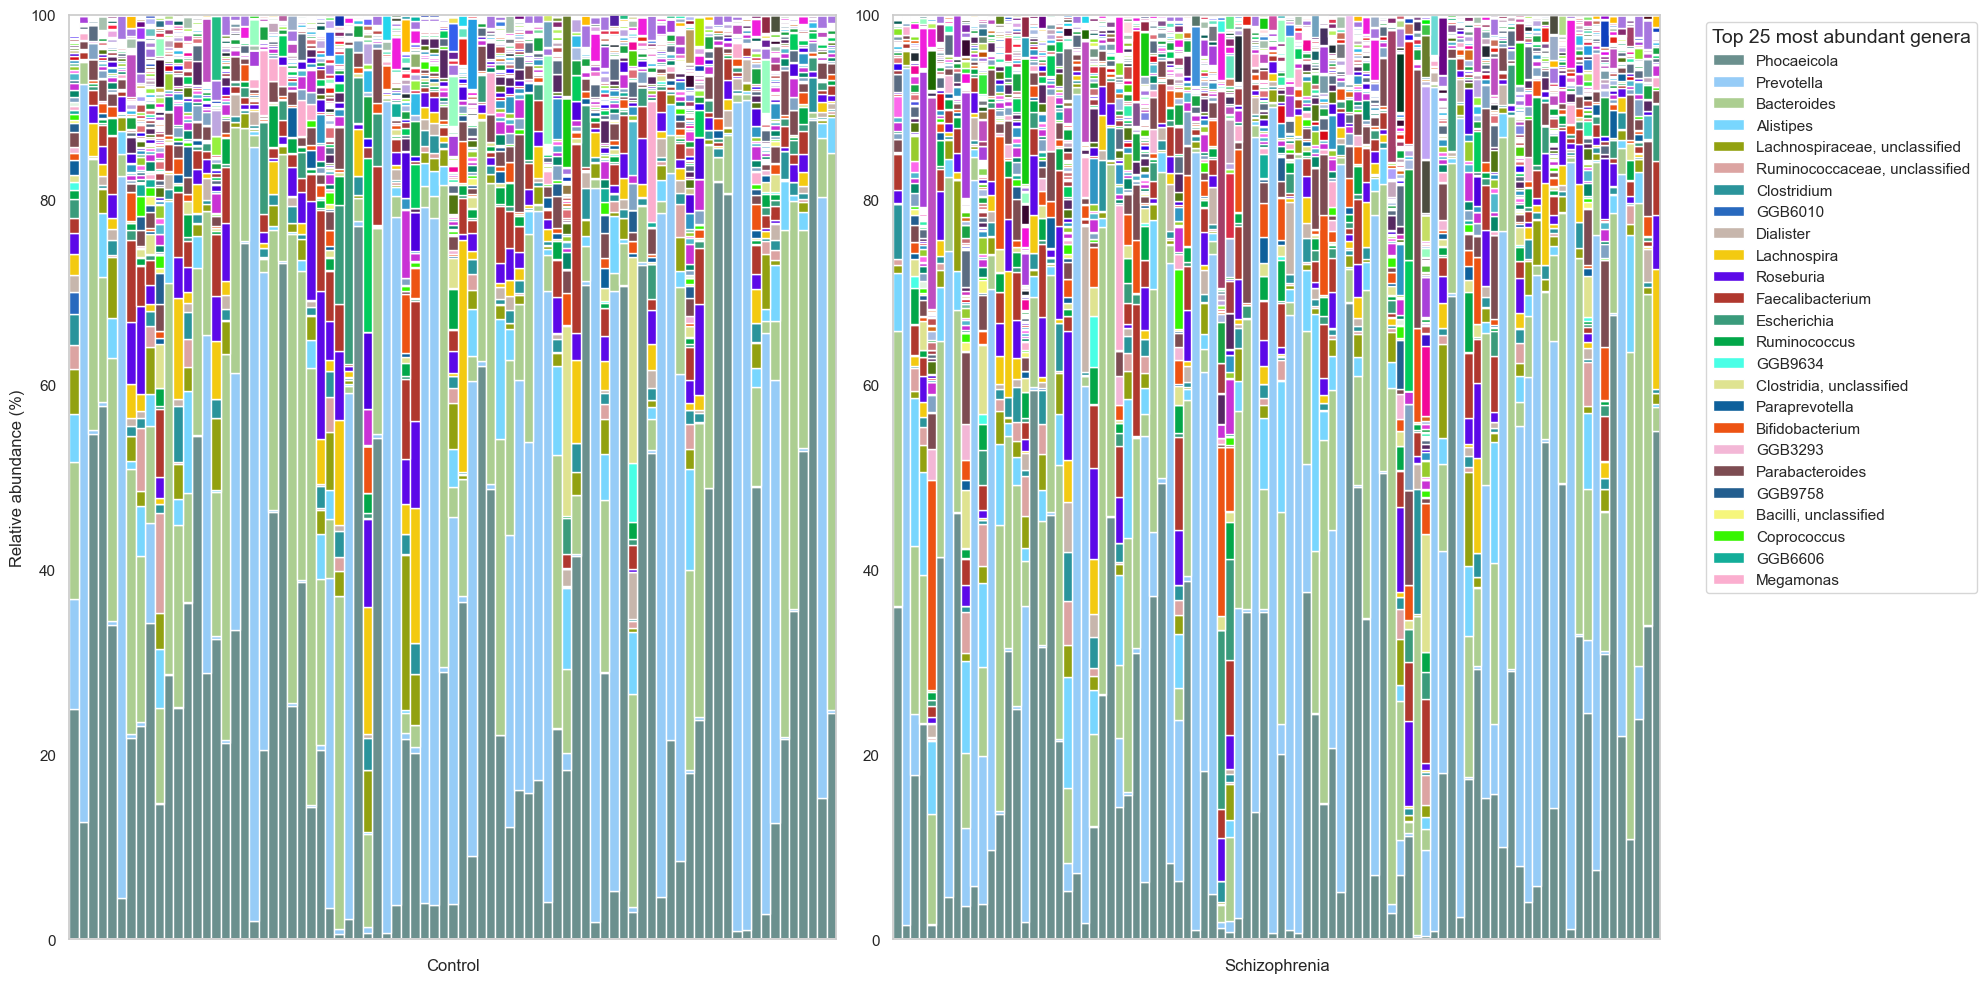

In [9]:
df_genus = df[(df.index.str.contains("g__")) & ~(df.index.str.contains("s__"))]
df_genus_rel_ab = df_genus.apply(lambda x: x * 100 / sum(x), axis=0).copy()

fig = data_visualization.plot_genus(
    df_genus_rel_ab,
    df_metadata[df_metadata["Group"] == "HC"].index.to_list(),
    df_metadata[df_metadata["Group"] == "SCZ"].index.to_list(),
)

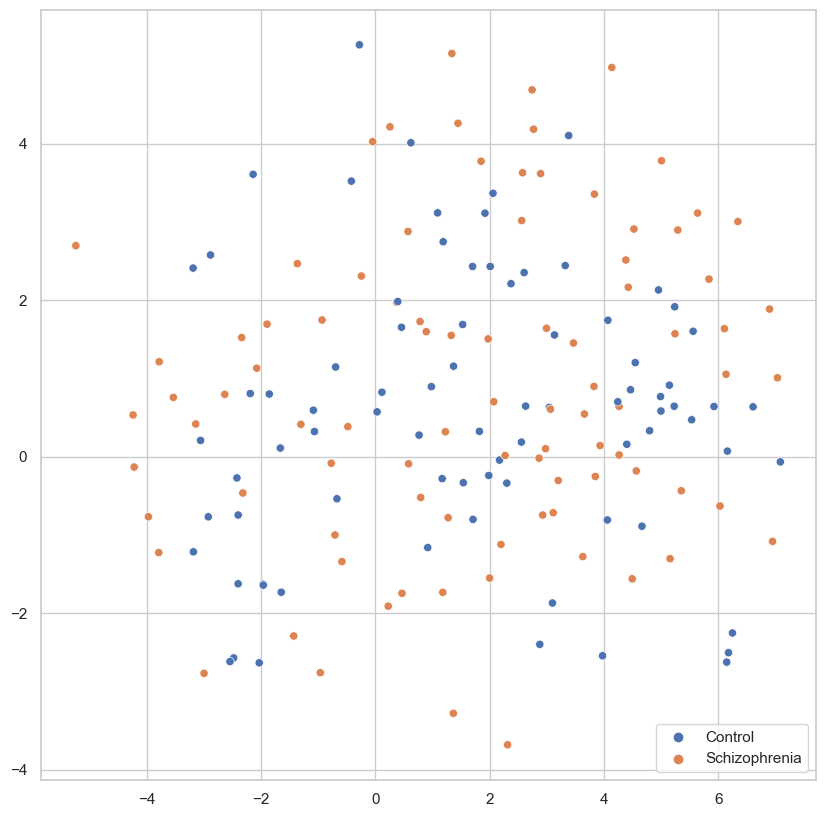

In [10]:
df_clr = pre_process.clr_transform(df_genus).T

fig = data_visualization.plot_tsne(df_clr, df_metadata["Group"], 11)

Key takeaways:
- There are no immediately obvious differences in the microbiota's composition of individuals with or without schizophrenia. That doesn't mean, however, that ML algorithms won't be able to learn the subtle differences present in a complex dataset.

**Best practices:**

- **Thoroughly characterize study population demographics.** We now have a better understanding of the dataset we are working with (e.g., size, complexity) and population demographics of study participants (e.g., distribution of diagnoses, centers where samples were collected). This is important for understanding the type of data on which a model was trained and can also provide insights that are important for optimizing experimental design. For example, if this dataset contained a severe class imbalance (it does not; it consists of 90 individuals with diagnosed schizophrenia and 81 without), we might plan to address that through the application of cost-sensitive training or SMOTE. 

## Data pre-processing 

Before using data for ML, we will do some pre-processing to ensure is it of the highest possible quality for input to our classifier. Namely, we will:
- Apply the centered log ratio (CLR) transformation to microbiome data to account for compositionality
- Filter out metadata features which may introduce bias into our ML models
- One hot encode categorical features and target labels

Note that in order to avoid data leakage, across-sample data pre-processing (e.g., feature scaling) must be applied only once the training-test split has been made for evaluating model performance. Those steps must be reserved for when we perform nested CV. 

To account for the compositionality of microbiomics data, we will apply the centered log ratio (CLR) transformation. We will avoid using relative abundance due to the spurious correlations which it can introduce.

In [11]:
tax_levels = ["all", "species", "genus", "family"]
data_dict = defaultdict(lambda: defaultdict())

for tax_level in tax_levels[1:]:
    _ = pre_process.get_tax_level(df, tax_level)
    data_dict["microbiome_only"][tax_level] = pre_process.clr_transform(_).T

data_dict["microbiome_only"]["all"] = pre_process.clr_transform(df).T

For metadata, we will retain only features that derive from clinical measurements. Including behavioural factors may lead to unintentional data leakage, for example if people diagnosed with schizophrenia (or a different stage thereof - first episode vs relapse) are likely to make certain types of lifestyle decisions that take this diagnosis into account. For example, we will not include sampling center as a feature because an individual with schizophrenia may choose to frequent a medical facility that specializes in the treatment of schizophrenia, while people without schizophrenia may have different selection criteria for medical facility.

In [12]:
X_metadata_only = df_metadata[
    [
        "Age",
        "Height(cm)",
        "Weight(kg)",
        "Pulse(c. p. m)",
        "Breathe(c. p. m)",
        "Systolic pressure(mmHg)",
        "Diastolic pressure(mmHg)",
        "Tryptophane(μM)",
        "Glutamic acid(μM)",
        "Tyrosine(μM)",
        "Phenylalanine(μM)",
        "Dopamine(ng/ml)",
        "Gamma-aminobutyric acid  (GABA)(ng/L)",
        "Serotonin(ng/ml)",
        "Kynurenine (KYN)(nmol/L)",
        "Kynurenic acid (KYNA)(nmol/L)",
    ]
]
metadata_continuous_cols = X_metadata_only.columns

Now we will one hot encode categorical features for ML (here, gender)

In [13]:
gender = pd.get_dummies(df_metadata["Gender (1:male, 2:female)"])
X_metadata_only = pd.merge(X_metadata_only, gender, left_index=True, right_index=True)
X_metadata_only.rename(columns={1: "Male", 2: "Female"}, inplace=True)

X_metadata_only = X_metadata_only.astype(float)
data_dict["metadata_only"]["all"] = X_metadata_only

Encode target labels

In [14]:
# Encode labels
encoder = LabelEncoder()
y_encoded = pd.Series(encoder.fit_transform(df_metadata['Group']))

Now we will create a dictionary that has "metadata only", "microbiome only", and combined features, and save the data such that it can be used for training models on the cloud. 

In [15]:
data_dict = pre_process.merge_metadata_microbiome(data_dict, tax_levels)

In [16]:
# Save data_dict and y_encoded as pickle files
with open("./data_dict.pickle", "wb") as data_dict_file:
    dill.dump(data_dict, data_dict_file)

with open("./y_encoded.pickle", "wb") as y_encoded_file:
    dill.dump(y_encoded, y_encoded_file)

**Best practices:**
- **Carefully identify and frame appropriate ML tasks.** We clearly indicate which features will be used as input to ML models (e.g., age, height (cm), weight (kg), ..., kynurenic acid (nmol/L)) rather than providing vague descriptors such as "clinical characteristics of patients". 
- **Account for the compositional nature of microbiomics data.** We have applied the CLR transformation to avoid the pitfalls associated with using relative abundance for machine learning.
- **Understand and avoid test set omission and leakage.** Before begining our experiment, we planned to use repeated k-fold CV for model training and evaluation. Because there will be no static training-test split, during the data pre-processing have intentionally avoided applying any transformations (e.g., feature scaling) that require calculating statistical information from the dataset. These will instead be done during the repeated k-fold CV process on individual training folds. Note that if our experimental design included performing feature selection prior to training an ML model (e.g., using DESeq2), feature selection would also be done per training-test split to avoid data leakage. 

## Perform model training and hyperparameter optimization using repeated k-fold CV

To train and evaluate models, we will use repeated k-fold CV. The use of repetitions will allow us to decrease the noise in our estimate of model performance. We will use 10-folds and 10 repetitions, giving us a total of 100 replicates. Note that the dataset contains 90 individuals with diagnosed schizophrenia and 81 without - with stratified splits we will have multiple instances of both classes in each fold (this may not always be the case, depending on dataset size and class imbalance).

To avoid computational costs and delays associated with training the models, for the purposes of this tutorial they have been trained in advance. The code is still provided below (and via github) to illustrate the overall process.
    

In [18]:
if train_from_scratch = False:
    with open("./results.pickle", "rb") as results_file:
    results = dill.load(results_file)
else:

    from ml4microbiome import train, post_hoc, pre_process
    import numpy as np
    from collections import defaultdict
    import dill
    from sklearn.model_selection import RepeatedStratifiedKFold

    tax_levels = ["all", "species", "genus", "family"]
    data_types = ["metadata_only", "microbiome_only", "metadata_microbiome"]

    # Create list of numeric metadata features (will be feature scaled)
    metadata_continuous_cols = [
        "Age",
        "Height(cm)",
        "Weight(kg)",
        "Pulse(c. p. m)",
        "Breathe(c. p. m)",
        "Systolic pressure(mmHg)",
        "Diastolic pressure(mmHg)",
        "Tryptophane(μM)",
        "Glutamic acid(μM)",
        "Tyrosine(μM)",
        "Phenylalanine(μM)",
        "Dopamine(ng/ml)",
        "Gamma-aminobutyric acid  (GABA)(ng/L)",
        "Serotonin(ng/ml)",
        "Kynurenine (KYN)(nmol/L)",
        "Kynurenic acid (KYNA)(nmol/L)",
    ]

    # Define experimental parameters, e.g., hyperparameters and ranges thereof to tune
    learning_algs = ["random_forest", "lightGBM", "logistic_regression_L1"]
    reps = 10
    test_size = 0.2
    params_distributions = {
        "random_forest": {
            "n_estimators": np.arange(50, 550, 50),
            "max_features": ["log2", "sqrt", None],
            "min_samples_split": np.arange(2, 10, 2),
            "min_samples_leaf": np.arange(2, 12, 2),
            "bootstrap": [True, False],
            "max_depth": np.arange(5, 11),
        },
        "lightGBM": {
            "learning_rate": np.linspace(0.01, 0.5, 50),
            "objective": ["binary"],
            "boosting_type": ["gbdt"],
            "num_leaves": np.arange(25, 200, 25),
            "max_depth": np.arange(1, 10),
            "subsample": np.arange(0.5, 1.0, 0.1),
            "subsample_freq": np.arange(2, 10, 2),
            "colsample_bytree": np.arange(0.5, 1.0, 0.1),
            "min_child_weight": np.linspace(1e-4, 1e-5, 25),
            "reg_alpha": np.arange(0, 100, 25),
            "max_bin": np.arange(155, 355, 50),
            "min_child_samples": np.arange(10, 50, 10),
        },
        "logistic_regression_L1": {
            "max_iter": [10000],
            "penalty": ["l1"],
            "C": np.linspace(0.1, 100, 50),
            "solver": ["liblinear", "saga"],
        },
    }

In [19]:
with open("./data_dict.pickle", "rb") as data_dict_file:
    data_dict = dill.load(data_dict_file)

with open("./y_encoded.pickle", "rb") as y_encoded_file:
    y_encoded = dill.load(y_encoded_file)

- Baseline 1: always predicts the majority class in the training data
- Baseline 2: predicts classes based the frequency with which each appears in the training data
- Baseline 3: creates predictions using a random forest model trained using randomly shuffled target labels
- Baseline 4: creates predictions using a lightGBM model trained using randomly shuffled target labels
- Baseline 5: creates predictions using a logistic regression model trained using randomly shuffled target labels

In [20]:
try:
    with open("./results.pickle", "rb") as f:
        results = dill.load(f)
        print("Results file already exists, resuming experiment from where it left off")
except FileNotFoundError:
    print("No results file found, starting one from scratch")
    results = defaultdict(
        lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    )

No results file found, starting one from scratch


In [21]:
import time
n_reps = 10
k = 10

for data_type in data_types:
    for tax_level in tax_levels:
        # implement resume from checkpoint
        if data_type in results.keys() and tax_level in results[data_type].keys():
            continue
        for alg in learning_algs:
            t0 = time.time()
            if data_type == "metadata_only" and tax_level != "all":
                continue 
                
            print(f"Parameters: {data_type} {tax_level} {alg}")

            X = data_dict[data_type][tax_level]
            y = y_encoded
            rskf = RepeatedStratifiedKFold(n_splits=k, n_repeats=n_reps, random_state=42)
            rskf.get_n_splits(X, y)
            for i, (train_index, test_index) in enumerate(rskf.split(X, y)):
                # Get X and y training and test sets
                (
                    X_train, 
                    y_train, 
                    X_test, 
                    y_test 
                ) = (X.iloc[train_index], 
                y.iloc[train_index], 
                X.iloc[test_index], 
                y.iloc[test_index]
                )

                # Perform median imputation 
                # Stats are calculated on the training set and applied to the test set to avoid data leakage
                X_train = X_train.fillna(X_train.median())
                X_test = X_test.fillna(X_train.median())
                
                # Perform feature scaling on numeric metadata features
                # Stats must be calculated on the training set and applied to the test set to avoid data leakage
                if data_type != "microbiome_only":
                    X_train, X_test = pre_process.scale_features(
                        X_train, X_test, metadata_continuous_cols
                    )
                
                # Train the model
                model, params = train.tune_model(
                        alg,
                        params_distributions[alg],
                        "roc_auc",
                        X_train,
                        y_train,
                        i
                    )
                
                # Evaluate model and save results
                yhat = model.predict(X_test.to_numpy())
                auc, f1, cm = train.test_model(yhat, y_test)
                results = train.save_results(results, data_type, tax_level, alg, train_index, test_index, i, auc, f1, cm, yhat, model)
                
                # Evaluate baselines and save results                   
                # Only need to do this once, not for every combination of data_type, tax_level, and alg
                if data_type == "metadata_microbiome" and tax_level == "all" and alg == "random_forest":
                    print("baseline1")
                    b = train.baseline1(y_train, X_test.to_numpy())
                    auc, f1, cm = train.test_model(b, y_test)
                    results = train.save_results(results, "baseline1", tax_level, alg, train_index, test_index, i, auc, f1, cm, yhat, b)

                    b = train.baseline2(y_train, X_test.to_numpy(), i)
                    auc, f1, cm = train.test_model(b, y_test)
                    results = train.save_results(results, "baseline2", tax_level, alg, train_index, test_index, i, auc, f1, cm, yhat, b)
                    
                    for alg_b in ["random_forest", "lightGBM", "logistic_regression_L1"]:
                        b = train.baseline345(alg_b, X_train, y_train, i, params_distributions, X_test)
                        auc, f1, cm = train.test_model(b, y_test)
                        results = train.save_results(results, "baseline_"+alg_b, tax_level, alg, train_index, test_index, i, auc, f1, cm, yhat, b)
          
            print('loop took', time.time() - t0)
        t0 = time.time()
        with open("./results.pickle", "wb") as results_file:
            dill.dump(results, results_file)
        print('saving took', time.time() - t0)

Parameters: metadata_only all random_forest
loop took 318.97457003593445
Parameters: metadata_only all lightGBM
loop took 15.689708948135376
Parameters: metadata_only all logistic_regression_L1
loop took 41.1499981880188
saving took 13.93312931060791
saving took 10.16554594039917
saving took 10.162517070770264
saving took 10.11896276473999
Parameters: microbiome_only all random_forest
loop took 1972.7538678646088
Parameters: microbiome_only all lightGBM


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by 

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by 

loop took 425.96044182777405
Parameters: microbiome_only all logistic_regression_L1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


loop took 5533.244863986969
saving took 22.26106595993042
Parameters: microbiome_only species random_forest
loop took 807.8254311084747
Parameters: microbiome_only species lightGBM


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by 

loop took 145.59465384483337
Parameters: microbiome_only species logistic_regression_L1
loop took 1716.715098142624
saving took 34.93749213218689
Parameters: microbiome_only genus random_forest


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


loop took 557.0481908321381
Parameters: microbiome_only genus lightGBM


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


loop took 69.67754602432251
Parameters: microbiome_only genus logistic_regression_L1
loop took 827.3339810371399
saving took 48.725598096847534
Parameters: microbiome_only family random_forest
loop took 410.4843430519104
Parameters: microbiome_only family lightGBM


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


loop took 34.77105093002319
Parameters: microbiome_only family logistic_regression_L1
loop took 238.32524991035461
saving took 59.29568099975586
Parameters: metadata_microbiome all random_forest
baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1
baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1
baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1
baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1
baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1
baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1
baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


baseline1
baseline1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


loop took 10252.787535190582
Parameters: metadata_microbiome all lightGBM


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by 

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by 

loop took 460.1297559738159
Parameters: metadata_microbiome all logistic_regression_L1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


loop took 5565.268855810165
saving took 72.36161684989929
Parameters: metadata_microbiome species random_forest
loop took 763.1282222270966
Parameters: metadata_microbiome species lightGBM


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by 

loop took 158.06548285484314
Parameters: metadata_microbiome species logistic_regression_L1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


loop took 1688.1261739730835
saving took 84.16164588928223
Parameters: metadata_microbiome genus random_forest


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


loop took 545.5820727348328
Parameters: metadata_microbiome genus lightGBM
loop took 75.95739984512329
Parameters: metadata_microbiome genus logistic_regression_L1
loop took 840.5283880233765
saving took 98.45877623558044
Parameters: metadata_microbiome family random_forest
loop took 396.4417579174042
Parameters: metadata_microbiome family lightGBM


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


loop took 40.13115310668945
Parameters: metadata_microbiome family logistic_regression_L1


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


loop took 230.54993724822998
saving took 110.50770998001099


Let's load the results:

In [22]:
with open("./results.pickle", "rb") as results_file:
    results = dill.load(results_file)

In [23]:
results_overview, results_auroc = train.results_overview_table(results)

In [24]:
results_overview

,Data type,Taxonomic level,ML algorithm,Median AUROC,MAD AUROC,F1,MAD F1,TN,MAD TN,FP,MAD FP,FN,MAD FN,TP,MAD TP
6,microbiome_only,species,random_forest,0.756944,0.062500,0.777778,0.064327,5.0,1.0,1.0,1.0,3.0,1.0,8.0,1.0
8,microbiome_only,species,logistic_regression_L1,0.753472,0.062500,0.714286,0.085714,7.0,1.0,3.0,1.0,1.0,1.0,6.0,1.0
7,microbiome_only,species,lightGBM,0.756944,0.062500,0.769841,0.063959,6.0,1.0,2.0,1.0,2.0,1.0,7.0,1.0
9,microbiome_only,genus,random_forest,0.722222,0.076389,0.761905,0.080201,6.0,1.0,2.0,1.0,2.0,1.0,7.0,1.0
11,microbiome_only,genus,logistic_regression_L1,0.708333,0.062500,0.705882,0.071895,6.0,1.0,3.0,1.0,2.0,1.0,6.0,1.0
10,microbiome_only,genus,lightGBM,0.666667,0.076389,0.697826,0.072826,6.0,1.0,3.0,1.0,2.0,1.0,6.0,1.0
12,microbiome_only,family,random_forest,0.694444,0.076389,0.716578,0.063616,5.0,1.0,3.0,1.0,3.0,1.0,6.0,1.0
14,microbiome_only,family,logistic_regression_L1,0.649306,0.062500,0.666667,0.078431,5.0,1.0,3.0,1.0,3.0,1.0,6.0,1.0
13,microbiome_only,family,lightGBM,0.645833,0.069444,0.679487,0.075000,5.0,1.0,3.0,1.0,3.0,1.0,6.0,1.0
3,microbiome_only,all,random_forest,0.760417,0.059028,0.777778,0.064327,6.0,1.0,1.0,1.0,2.0,1.0,8.0,1.0


Is this model statisticall signficantly better than others?

In [25]:
idx = results_overview['Median AUROC'].idxmax()
print("Data type:", results_overview.loc[idx]["Data type"], "\n",
      "Taxonomic level:", results_overview.loc[idx]["Taxonomic level"], "\n",
      "ML algorithm:", results_overview.loc[idx]["ML algorithm"], "\n",
      "Median AUROC:", results_overview.loc[idx]["Median AUROC"], "\n",
      "MAD AUROC:", results_overview.loc[idx]["MAD AUROC"],
     )

Data type: metadata_microbiome 
 Taxonomic level: family 
 ML algorithm: random_forest 
 Median AUROC: 0.9375 
 MAD AUROC: 0.05902777777777779


Key points:

**Best practices:**

- **Perform a thorough exploration of ML experimental variables during training.** Here, we're testing different types of features (data types, taxonomic levels) and learning algorithms. We performed hyperparameter tuning during training to optimize model performance per experimental condition.
- **Understand and avoid test set omission.** Data transformations (imputation, feature scaling) that involved calculating statistical information across samples have been perform on training sets and applied to test sets. Note that if our experimental design included performing feature selection prior to training an ML model, feature selection would also be done per training-test split to avoid data leakage.
- **Comprehensively evaluate model performance.** 
    - This includes reporting multiple metrics for evaluating performance, such as AUROC, F1 score, amongst others.  
    - Critically, when experimental replicates are performed, summary statistics should provide a measure of central tendency (here, median) and variation (here, median absolute deviation). 
    - Based on how we designed the experiment, we have set the stage for further rigorouous model evaluation by training baseline models that we will compare our models against (see below). 
    - Note that while we have identified the top performing model based on median AUROC, we avoided making claims about this model's performance (or the combination of experimental parameters used to train it) being superior to that of others before evaluating whether this claim is statistically supported (see below).
- **Ensure that your work is reproducible.** During training, setting seeds for training-test splits and model initialization improves the reproducibility of experiments. It can also help experimenters downstream if they want to reproduce training-test partitions for further analysis (below we will recreate them for our SHAP analysis).

### Interpretation of repeated k-fold CV experimental results

The primary goals of our experiment was to answer the following questions:
1. Does the microbiome have predictive value for the diagnosis of schizophrenia?
2. If yes, which experimental ML parameters yield the model/s with the highest predictive power?

**Aim 1**

To evaluate whether the microbiome has predictive value for the diagnosis of schizophrenia, we will compare the performance of classifiers trained using microbiome data against our baseline models.

In [26]:
out = stats.convert_df_for_stats(results_auroc)
out.groupby("Data type")["AUROC"].agg(['median', stats.MAD])

,median,MAD
Data type,,
baseline1,0.500000,0.000000
baseline2,0.493056,0.083333
baseline_lightGBM,0.500000,0.000000
baseline_logistic_regression_L1,0.479167,0.086806
baseline_random_forest,0.513889,0.069444
metadata_microbiome,0.881944,0.055556
metadata_only,0.888889,0.055556
microbiome_only,0.708333,0.062500


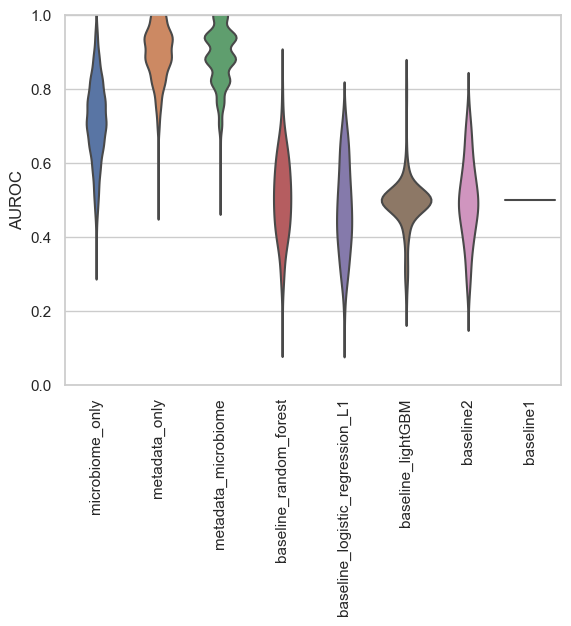

In [27]:
fig = data_visualization.plot_data_type(out)

We will perform statistical testing to evaluate whether, over all replicates, there are significant differences in the performance of baseline models vs microbiome-based models.

In [28]:
kw,dunn = stats.kruskal_dunn(out, "Data type", "AUROC")

In [29]:
kw

KruskalResult(statistic=2059.572897338765, pvalue=0.0)

In [30]:
dunn

,baseline1,baseline2,baseline_lightGBM,baseline_logistic_regression_L1,baseline_random_forest,metadata_microbiome,metadata_only,microbiome_only
baseline1,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.901539e-95,2.100690e-82,6.161846e-20
baseline2,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.028966e-89,9.484759e-78,1.959145e-17
baseline_lightGBM,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.679423e-94,9.154785e-82,1.376609e-19
baseline_logistic_regression_L1,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.519149e-93,1.447616e-80,6.151582e-19
baseline_random_forest,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.568819e-88,4.256821e-76,1.436963e-16
metadata_microbiome,2.901539e-95,1.028966e-89,1.679423e-94,4.519149e-93,9.568819e-88,1.000000e+00,1.000000e+00,2.035641e-183
metadata_only,2.100690e-82,9.484759e-78,9.154785e-82,1.447616e-80,4.256821e-76,1.000000e+00,1.000000e+00,2.334207e-82
microbiome_only,6.161846e-20,1.959145e-17,1.376609e-19,6.151582e-19,1.436963e-16,2.035641e-183,2.334207e-82,1.000000e+00


Interpretation: 

- Our results suggest that the microbiome holds predictive power for the diagnosis of schizophrenia as models trained using microbiome data outperformed baselines models that did not (baseline 1: p=XX, baseline 2: p=YY, baseline 3: p=ZZ, baseline 4: p=YY, baseline 5: p=YY). 
- That said, the microbiome alone appears to hold less predictive power than metadata alone (p = 2.07e-82). Combining metadata with microbiome data neither lessened nor augmented model performance compared to using metadata alone (p = 1e+00). 

Best practices:
- Perform replicates of your experiment when dataset size is small, as there can be a wide range of performance due to factors such as the training-test split.
- Compare against baselines
- Multiple evaluation metrics and report MAD

**Aim 2**

Let's examine how different experimental parameters influenced model performance. Note that for taxonomic level, we will only consider microbiome and combined data types because metadata does not have different bacterial taxonomic levels.

First we'll look at the effect that taxonomic level had on AUROC.

In [31]:
# remove baseline models from consideration
baselines = "baseline1", "baseline2", "baseline_random_forest", "baseline_lightGBM", "baseline_logistic_regression_L1"
out = out[out["Data type"].isin(baselines) == False]

In [32]:
out[out["Data type"]!="metadata_only"].groupby("Taxonomic level")["AUROC"].agg(['median', stats.MAD])

,median,MAD
Taxonomic level,,
all,0.819444,0.069444
family,0.770833,0.118056
genus,0.819444,0.111111
species,0.826389,0.069444


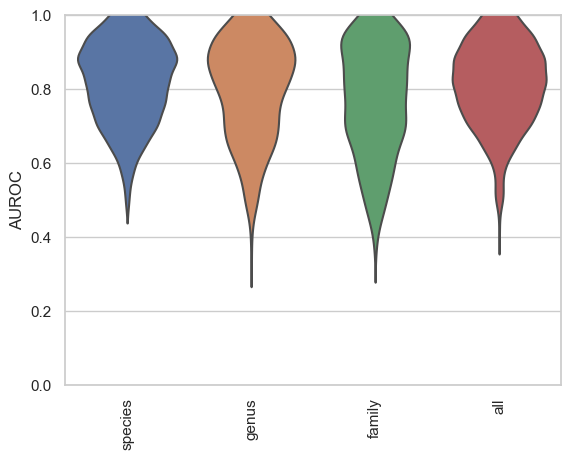

In [33]:
fig = data_visualization.plot_tax_level(out[out["Data type"]!="metadata_only"])

In [34]:
kw,dunn = stats.kruskal_dunn(out[out["Data type"]!="metadata_only"], "Taxonomic level", "AUROC")

In [35]:
kw

KruskalResult(statistic=38.06708689422447, pvalue=2.735531436886419e-08)

In [36]:
dunn

,all,family,genus,species
all,1.000000,8.015743e-06,0.998208,1.000000e+00
family,0.000008,1.000000e+00,0.003359,5.808192e-08
genus,0.998208,3.359039e-03,1.000000,1.335687e-01
species,1.000000,5.808192e-08,0.133569,1.000000e+00


Interpretation:
- The results suggest that:
    - Species, genus, and all taxonomic levels combined tend to perform equally well to one another 
    - Family tends to underperform compared to the other taxonomic levels tested here

Now let's look at the effect that learning algorithm had on AUROC.

In [37]:
out.groupby("ML algorithm")["AUROC"].agg(['median', stats.MAD])

,median,MAD
ML algorithm,,
lightGBM,0.833333,0.104167
logistic_regression_L1,0.826389,0.111111
random_forest,0.826389,0.076389


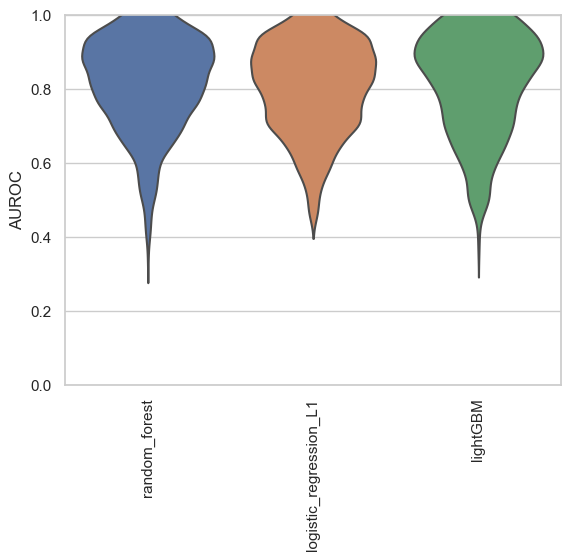

In [38]:
fig = data_visualization.plot_ml_alg(out)

In [39]:
# Too dense to plot individual dots --- 1350 data points

In [40]:
kw, dunn = stats.kruskal_dunn(out, "ML algorithm", "AUROC")

In [41]:
kw

KruskalResult(statistic=5.414000551561485, pvalue=0.06673669844573366)

In [42]:
dunn

,lightGBM,logistic_regression_L1,random_forest
lightGBM,1.000000,0.062822,1.000000
logistic_regression_L1,0.062822,1.000000,0.481913
random_forest,1.000000,0.481913,1.000000


Interpretation:
- The results suggest that lightGBM and logistic regression (L1) models had a tendency to outperform those trained using the random forest algorithm (RF vs LR: p=5.7e-5, RF vs LGBM: p=8.6e-11), although this was not always the case. 
- Overall, the performance of lightGBM and logistic regression (L1) models were similar (p=0.07).

Out of curiousity, let's investigate the range in performance that we saw within models:

From the violin part, we can see that for any data type / set of experimental parameters, there is a wide range in model performance. For our one of our highest performing experimental conditions, let's look at the range in model performance. 

In [43]:
condition = results["metadata_microbiome"]["species"]["lightGBM"]["AUROC"]
min(condition), max(condition), np.median(condition)

(0.5, 1.0, 0.8888888888888888)

Even with one of our highest performing experimental conditions, model trained on a single data split could score an AUROC as low as 0.5.

Similarly, we can see that some of the least successful experimental conditions can still sometimes result in high AUROC scores.

In [44]:
condition = results["microbiome_only"]["family"]["logistic_regression_L1"]["AUROC"]
min(condition), max(condition), np.median(condition)

(0.4583333333333333, 0.8888888888888888, 0.6493055555555556)

This highlights the importance of training and evaluating experimental replicates using different non-deterministic settings (e.g., training-test splits) when working with small datasets. 

**Best practices:**
- **Carefully identify and frame appropriate ML tasks.** Study goals were explictly presented and, correspondingly, were directly addressed. This allows readers to understand what was done, why, and what the implications of the research are.
- **Comprehensively evaluate model performance.** 
    - Where dataset size is small, experimental replicates help provide more robust estimates of model performance. With this dataset and experimental protocol, we can see that there was substantial variability in the performance of models trained using the same parameters on different folds due to heuristic differences. If we had a single, static training-test split, the resulting performance could be anything within those ranges and would not necessarily reflect the predictive performance of a model / set of experimental parameters.
    - Claims about certain experimental parameters or models being superior to others should be backed up with statistical comparisons where experimental replicates are implemented. Seemingly small differences may be significant, while seemingly large differences may not be. 
    - Comparisons of baseline models against experimental models provided context into the difficulty of the problem and how well experimental models performed.

## Perform model interpretation

Aim 3 of our study is to gain scientific insight into which bacterial taxa provide value for predicting whether an individual has schizophrenia. Such taxa are of interest because they may play a causative role in the pathogenesis of schizophrenia. It is important to note, however, that preliminary analyses such as this are hypothesis generating and cannot offer insights into whether taxa of interest are correlative vs causative. 

To understand how much each feature contributes to the model's performance, we will calculate SHAP values. SHAP values can help you understand which features are the most important to the model and how they affect model predictions. As a caveat, one of the assumptions of SHAP is that features are not correlated, which is unlikely to be strictly true in complex microbial communities 

We will compute SHAP values for our model / experimental condition that used microbiome data only, at the species level, using the random forest learning algorithm. This high-performing model will provide us with high resolution into microbial taxa with predictive value to the model. For each of 100 replicate models that was trained, we will recreate the extact training-test split used to train it (remember we saved the seeds and indices) and use that data to calculate SHAP values.

Due to the time it takes to compute SHAP values, we have precomputed and saved them. By default, this notebook will load the precomputed SHAP values.

In [48]:
# Generate SHAP values (removed from code above to save time)
data_type = "microbiome_only"
tax_level = "species"
alg = "random_forest"
expt = results[data_type][tax_level][alg]
models, train_indices, test_indices = expt["model"], expt["train_index"], expt["test_index"]

shap_dict = {}

X = data_dict[data_type][tax_level]
y = y_encoded

test_idx_for_shap = []
X_test_for_shap = []
y_test_for_shap = []

for rep in range(len(models)): # for each of 100 models
    print(rep)
    model, train_idx, test_idx = models[rep], train_indices[rep], test_indices[rep]
    
    # get X_train, y_train, X_test, y_test used for training and evaluation of current model
    (
        X_train, 
        y_train, 
        X_test, 
        y_test 
    ) = (X.iloc[train_indices[rep],:], 
    y.iloc[train_indices[rep]], 
    X.iloc[test_indices[rep],:], 
    y.iloc[test_indices[rep]]
    )

    # Repeat median imputation 
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())
    
    # Repeat feature scaling if applicable
    if data_type != "microbiome_only":
        X_train, X_test = pre_process.scale_features(
            X_train, X_test, metadata_continuous_cols
        )

    shap_vals = post_hoc.shap_(model, X_test)
    shap_dict[rep] = shap_vals
    test_idx_for_shap.append(test_idx)
    X_test_for_shap.append(X_test)
    y_test_for_shap.append(y_test)

0
1
2
3
4


Permutation explainer: 18it [00:10, 10.35s/it]                                  


5
6
7
8


Permutation explainer: 18it [00:11,  3.94s/it]                                  


9
10


Permutation explainer: 19it [00:10, 10.24s/it]                                  


11
12


Permutation explainer: 18it [00:10, 10.15s/it]                                  


13
14
15
16
17


Permutation explainer: 18it [00:10, 10.50s/it]                                  


18
19
20


Permutation explainer: 19it [00:11,  2.95s/it]                                  


21
22


Permutation explainer: 18it [00:11,  5.61s/it]                                  


23


Permutation explainer: 18it [00:10, 10.34s/it]                                  


24
25
26
27


Permutation explainer: 18it [00:12,  3.19s/it]                                  


28
29
30


Permutation explainer: 19it [00:13,  2.73s/it]                                  


31
32
33


Permutation explainer: 18it [00:12,  3.17s/it]                                  


34


Permutation explainer: 18it [00:10, 10.04s/it]                                  


35
36
37
38


Permutation explainer: 18it [00:10, 10.45s/it]                                  


39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


Permutation explainer: 18it [00:11,  5.62s/it]                                  


57
58


Permutation explainer: 18it [00:10, 10.29s/it]                                  


59
60
61
62
63
64
65
66
67
68


Permutation explainer: 18it [00:10, 10.18s/it]                                  


69
70
71
72


Permutation explainer: 18it [00:16,  2.32s/it]                                  


73
74
75
76
77


Permutation explainer: 18it [00:11,  3.90s/it]                                  


78


Permutation explainer: 18it [00:13,  2.62s/it]                                  


79
80


Permutation explainer: 19it [00:11,  3.86s/it]                                  


81
82
83
84


Permutation explainer: 18it [00:11,  5.69s/it]                                  


85


Permutation explainer: 18it [00:14,  2.43s/it]                                  


86
87
88
89
90
91


Permutation explainer: 18it [00:11,  3.97s/it]                                  


92


Permutation explainer: 18it [00:10, 10.26s/it]                                  


93


Permutation explainer: 18it [00:11,  5.70s/it]                                  


94
95
96


Permutation explainer: 18it [00:10,  5.38s/it]                                  


97
98
99


Permutation explainer: 18it [00:11,  5.53s/it]                                  


In [49]:
import pickle

with open('shap_dict.pickle', 'wb') as handle:
    pickle.dump(shap_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

To merge SHAP values from a repeated CV experiment, we will:
- Run SHAP package on each fold, to calculate SHAP values for each sample in each test set fold
    - Here, for each of 100 replicates/folds, we calculate SHAP values for each of 17, or occasionally 18, samples (# samples in X_test)
    - In total, there end up being SHAP values for 1710 samples across all 100 folds  

- Merge SHAP values from each sample and each test set fold and plot
    - 1710 SHAP value arrays, each of length 2456 (# features)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


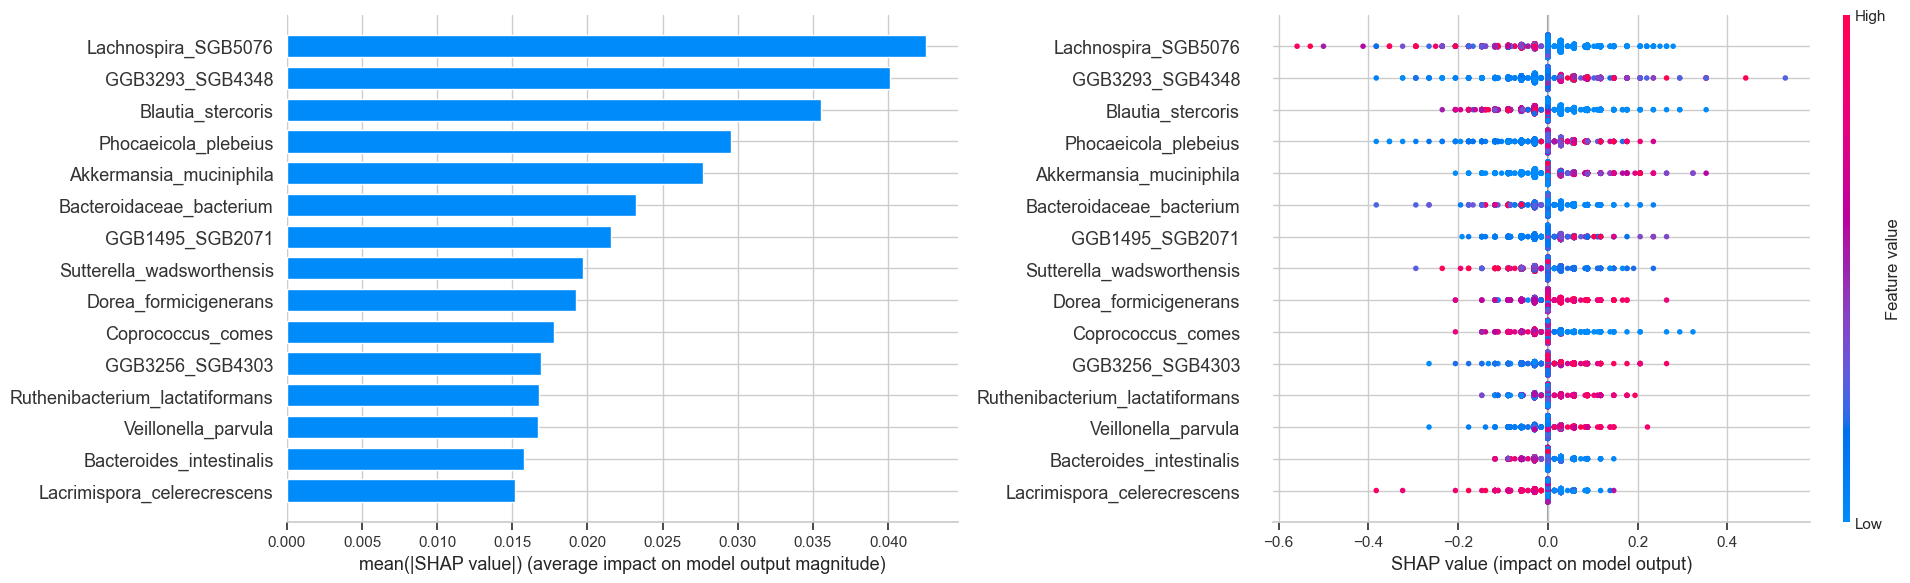

In [50]:
fig = post_hoc.plot_shap(shap_dict, X_test_for_shap, X.columns)

In [130]:
X.columns[X.columns.str.contains("GGB3293_SGB4348")]

Index(['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_unclassified|f__Clostridia_unclassified|g__GGB3293|s__GGB3293_SGB4348'], dtype='object', name='clade_name')

Interpretation:
- From the SHAP bar plot, we can identify bacterial taxa that have the greatest average impact on model output magnitude. Here, the top 5 most strongly contributing species to model predictions are *Lachnospira SGB5076*, *GGB3293 SGB4348* (f__Clostridia_unclassified), *Blautia stercoris*, *Phocaeicola pkebeius*, and *Akkermansia muciniphila*. 
- We can see from the beewarm plot that, for example, a high abundance of *Lachnospira SGB5076* correlates with the model predicting no schizophrenia, while low abundances are correlated with the model predicting schizophrenia.    
- From here, next steps within a study could include performing a literature review focused around these taxa to better understand the potential signficiance to schizophrenia.

**Best practices:**
- **Comprehensively evaluate model performance.** Understanding how a model performs includes understanding why it makes the predictions that it does. An important part of this is understanding which features a model considers, to what extent and in what context. In addition to providing scientific insights, such analyses can also help catch potential cases of short cut learning (e.g., if the top predictors were all common laboratory contaminants that a model used to predict which center a sample was collected/processed at, and then made predictions about presence of absence of schizophrenia based on the frequency of patient types seen at that center) or other errors (e.g., a coding bug where you thought we were conducting the experiment at the level of genus but you were actually using strain).
- **Stay up to date on new research and experiment with new techniques.** The SHAP package was released relatively recently (~5 yrs ago at the time of publication) and provides substantial benefits for model interpretation compared to other approaches. Staying on top of innovations and new discoveries, especially in the rapidly evolving field of ML, can benefit your research.

## Perform error analysis

Finally, we will garner insights into the distribution of errors in our model beyond aggregate, target class level performance metrics. This can provide direction for how to improve future iterations of the model as well as inform us of where our model may be biased / perform particularly well or poorly. 

In [135]:
errs_per_sample, occurence, count_errs = post_hoc.calc_errs_per_sample(results, 
                                                                       data_type, 
                                                                       tax_level, 
                                                                       alg, 
                                                                       y_encoded)

First, let's look at how often each instance was sampled to be in the test set of the repeated k-fold CV experiment that we conducted:

In [136]:
# occurence dict: keys = sample index, values = # of times it occured in the test set
set(occurence.values())

{10}

Each instance was included in the test set exactly 10 times. Because all instances were sampled an equal number of times, we will proceed by treating each replicate as an independent sample during our error analysis. 

Now let's look at the distribution of errors across original instances.

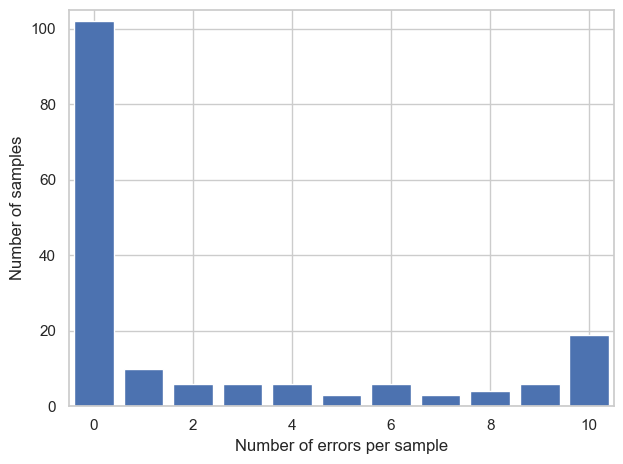

In [145]:
fig = post_hoc.plot_distrib_errs(count_errs)

We can see that some samples are misclassified more often than others. For example, there are 102 samples that were never misclassified in any experimental replicate, while there were 19 samples that were always incorrectly classified. How come? Are there any common properties of the patients from whom those samples were derived?

To gain insights into these questions, we'll start by identifying cohorts with high error rates. Below, we will plot barplots for each demographic feature. The x-axis will show population subsets, the y-axis will show percent errors, and we will denote in text above each bar the total number of instances from each category that was included in the dataset (e.g., there were 84 females and 87 males in the dataset). Note that because each sample was included in the test set 10 times, were are plotting data from 10 * n_samples.

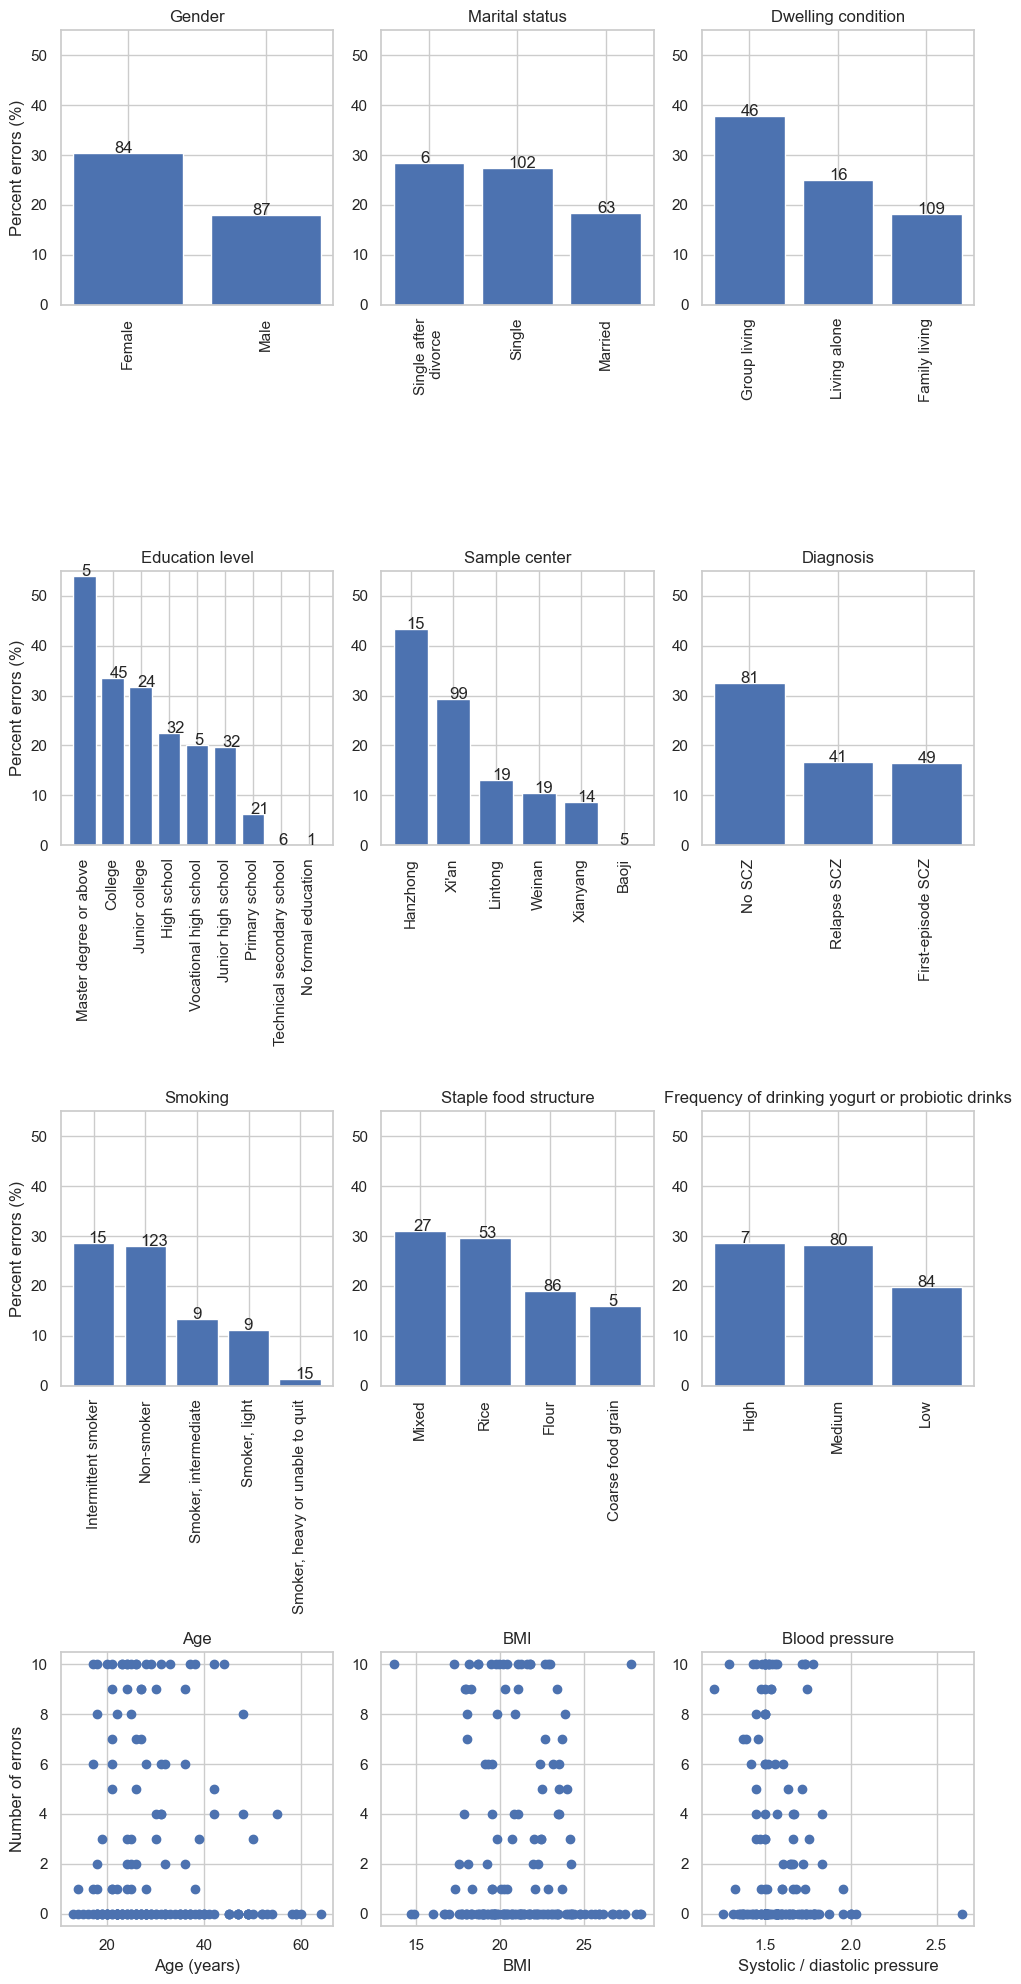

In [161]:
fig = post_hoc.plot_err_breakdown(df_metadata, errs_per_sample, occurence)

Through visual inspection, we can see that some demographic characteristics appear to be associated with higher error rates than others. For example, people with a master degree or higher have a higher error rate compared to those with less education. Similarly, we can see that the error rate per sample center is heterogeneous, with participants from Hanzhong having a higher error rate >2X that of participants recruited from Lintong, Weinan, Xianyang, and Baoji. 

Such insights may spur investigators to query why they see certain error patterns while also potentially providing clues as to how one could improve model performance in the future (e.g., increase sample size of a particularly poorly represented demographic group in the dataset with a high error rate).

We can also look at how error themes interact between multiple features using a heatmap. 

In [155]:
post_hoc.dataset_wide_err(count_errs, occurence)

The dataset wide error rate is 24.09%


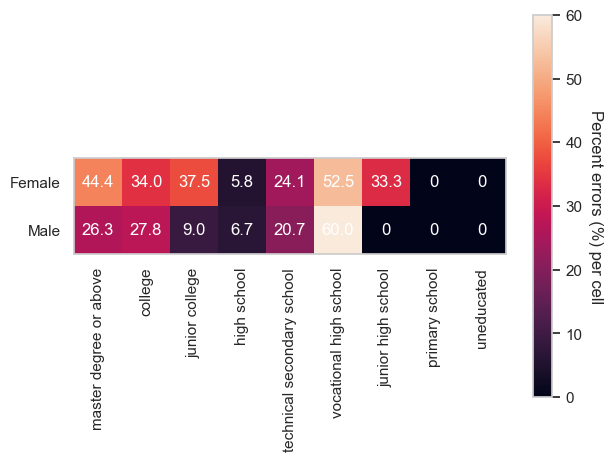

In [109]:
var1 = "Gender (1:male, 2:female)"
var2 = "Education level"

fig = post_hoc.interaction_heatmap(var1, 
                                   var2, 
                                   df_metadata[var1].unique(), 
                                   df_metadata[var2].unique(), 
                                   df_metadata, 
                                   errs_per_sample, 
                                   occurence)

When we plot the interaction of error rate for gender and education level, we can see that while overall the error rate for our dataset was 24.09%, for men whose highest education level is vocational high school, the error rate was 60%. 

This provides us with valuable insights into understanding what features are impacting model performance. To dig deeper, one might next try to understand whether there was a correlation between error rate and the number of instances of women vs men with varying degrees of education.

Interpretation:
- Model performance varies substantially on different samples, with some samples being correctly being classified in all experimental replicates in which they were assigned to the test set, and others always being incorrectly classified. 
- Some of the demographic features that may correlate with lower model performance are gender (females have a higher error rate), education level, sample center, and smoking habits. 
- While the overall error rate for the model was 24%, it could be much higher (e.g., 60%) for some population segments.

**Best practices:**
- **Comprehensively evaluate model performance.** The distribution of errors in a model across population segments is likely to substantially differ. Such disparities are important to note for the sake of both trying to improve model performance across all population segments in the future and being transparent about model strengths and limitations. Ensuring fair and equal access to medical care necessitates that tools work well for patients from all demographic backgrounds. If they don't, precautions must be taken to disclose and remedy the situation. 

## Conclusion

Here, we developed an ML model for predicting whether an individual has schizophrenia on the taxonomic composition of their gut microbiota. 

The first aim of this study was to evaluate whether the gut microbiota has predictive value for diagnosing schizophrenia. To this end, we trained two sets of models using microbiome data. The first set of models were trained using taxonomic compositional data inferred using MetaPhlAn4, at the levels of species, genus, family, and all taxonomic levels (from strain to phylum) combined. The second set of models were trained on that same taxonomic compositional data plus metadata collected from study participants (e.g., age, height, weight, and blood based markers).


2) if so, what set of experimental parameters, including feature types, yield the highest performing model, and 3) if so, which microbial taxa hold predictive value to the model? 





## Works Cited

Andrews, S. "FastQC: a quality control tool for high throughput sequence data." (2010). Available online at: http://www.bioinformatics.babraham.ac.uk/projects/fastqc/.

Beghini, F., et al. "Integrating taxonomic, functional, and strain-level profiling of diverse microbial communities with bioBakery 3." elife 10 (2021): e65088.

Ewels, P., Magnusson, M., Lundin, S., Käller, M. "MultiQC: summarize analysis results for multiple tools and samples in a single report." *Bioinformatics* 32.19 (2016): 3047-3048.

Zhu, F., *et al*. "Metagenome-wide association of gut microbiome features for schizophrenia." *Nature communications* 11.1 (2020): 1612.

Langmead, B., Salzberg, S.L. "Fast gapped-read alignment with Bowtie 2." *Nature methods* 9.4 (2012): 357-359.